## Zad 17_2


Dla nauczonego modelu policz metryki wspomniane w poznanym module o klasyfikacji na zbiorze testowym oraz policz macierz omyłek.

Wynik prześlij Mentorowi jako Jupyter Notebook umieszczony w Twoim GitHubie.

## rowiazanie na koncu pliku


### Zad 17_1


### Zadanie: Random Forest
Podziel zbiór na treningowy i testowy, pamiętaj o stratyfikacji. Następnie naucz model Random Forest, z którego wyciągnij feature importance. Na podstawie tego wykonaj selekcję cech i weź jedynie te, których ważność jest większa niż 0.001. Nauczy nowy model Random Forest z wyborem hiperperparametrów, korzystając z GridSearch. Wykorzystaj poznane techniki do wektoryzacji.

Wyniki prześlij Mentorowi jako Jupyter Notebook umieszczony w Twoim GitHubie.

### rozwiazanie na koncu pliku

### import

In [1]:
import numpy as np
import pandas as pd
import string
import nltk
nltk.download("punkt")
nltk.download("punkt_tab")
nltk.download("wordnet")
nltk.download("omw-1.4")  # dodatkowe dane językowe (czasem potrzebne)

import itertools
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\monas\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\monas\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\monas\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\monas\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


### pobranie danych

In [2]:
spam_dataset = pd.read_csv('spam.csv', encoding = "ISO-8859-1", usecols=[0, 1], names=['Spam', 'Text'],
                           skiprows=1)
spam_dataset['Spam'] = spam_dataset['Spam'].replace(['ham', 'spam'], [0, 1])
spam_dataset

,Spam,Text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...
5568,0,Will Ì_ b going to esplanade fr home?
5569,0,"Pity, * was in mood for that. So...any other s..."
5570,0,The guy did some bitching but I acted like i'd...


### normalizacja

In [3]:
# normalizacja i sprawdzenie czy spam
print(spam_dataset['Spam'].value_counts(normalize=True))

0    0.865937
1    0.134063
Name: Spam, dtype: float64


### usuniecie znaków przystankowych

In [4]:
def remove_puncation(text):
    cleaned = ''.join([word for word in text if word not in string.punctuation])
    return cleaned
spam_dataset['Cleaned_Text'] = spam_dataset['Text'].apply(lambda x: remove_puncation(x))
spam_dataset

,Spam,Text,Cleaned_Text
0,0,"Go until jurong point, crazy.. Available only ...",Go until jurong point crazy Available only in ...
1,0,Ok lar... Joking wif u oni...,Ok lar Joking wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...,U dun say so early hor U c already then say
4,0,"Nah I don't think he goes to usf, he lives aro...",Nah I dont think he goes to usf he lives aroun...
...,...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...,This is the 2nd time we have tried 2 contact u...
5568,0,Will Ì_ b going to esplanade fr home?,Will Ì b going to esplanade fr home
5569,0,"Pity, * was in mood for that. So...any other s...",Pity was in mood for that Soany other suggest...
5570,0,The guy did some bitching but I acted like i'd...,The guy did some bitching but I acted like id ...


### tokenizacja

In [5]:
def tokenize(text):
    # Usunięcie wielkich liter
    clean_text = text.lower()
    # Tokenizacja
    tokenized_text = nltk.word_tokenize(clean_text)
    return tokenized_text

spam_dataset['Tokenized_Text'] = spam_dataset['Cleaned_Text'].apply(lambda x: tokenize(x))
spam_dataset


,Spam,Text,Cleaned_Text,Tokenized_Text
0,0,"Go until jurong point, crazy.. Available only ...",Go until jurong point crazy Available only in ...,"[go, until, jurong, point, crazy, available, o..."
1,0,Ok lar... Joking wif u oni...,Ok lar Joking wif u oni,"[ok, lar, joking, wif, u, oni]"
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,Free entry in 2 a wkly comp to win FA Cup fina...,"[free, entry, in, 2, a, wkly, comp, to, win, f..."
3,0,U dun say so early hor... U c already then say...,U dun say so early hor U c already then say,"[u, dun, say, so, early, hor, u, c, already, t..."
4,0,"Nah I don't think he goes to usf, he lives aro...",Nah I dont think he goes to usf he lives aroun...,"[nah, i, dont, think, he, goes, to, usf, he, l..."
...,...,...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...,This is the 2nd time we have tried 2 contact u...,"[this, is, the, 2nd, time, we, have, tried, 2,..."
5568,0,Will Ì_ b going to esplanade fr home?,Will Ì b going to esplanade fr home,"[will, ì, b, going, to, esplanade, fr, home]"
5569,0,"Pity, * was in mood for that. So...any other s...",Pity was in mood for that Soany other suggest...,"[pity, was, in, mood, for, that, soany, other,..."
5570,0,The guy did some bitching but I acted like i'd...,The guy did some bitching but I acted like id ...,"[the, guy, did, some, bitching, but, i, acted,..."


### usuwanie stopwords

In [6]:
nltk.download("stopwords")
stopwords = nltk.corpus.stopwords.words("english")
stopwords
['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each',
 'few',
 'more',
 'most',
 'other',
 'some',
 'such',
 'no',
 'nor',
 'not',
 'only',
 'own',
 'same',
 'so',
 'than',
 'too',
 'very',
 's',
 't',
 'can',
 'will',
 'just',
 'don',
 "don't",
 'should',
 "should've",
 'now',
 'd',
 'll',
 'm',
 'o',
 're',
 've',
 'y',
 'ain',
 'aren',
 "aren't",
 'couldn',
 "couldn't",
 'didn',
 "didn't",
 'doesn',
 "doesn't",
 'hadn',
 "hadn't",
 'hasn',
 "hasn't",
 'haven',
 "haven't",
 'isn',
 "isn't",
 'ma',
 'mightn',
 "mightn't",
 'mustn',
 "mustn't",
 'needn',
 "needn't",
 'shan',
 "shan't",
 'shouldn',
 "shouldn't",
 'wasn',
 "wasn't",
 'weren',
 "weren't",
 'won',
 "won't",
 'wouldn',
 "wouldn't"]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\monas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [7]:
def remove_stopwords(text):
    without_stopwords = [word for word in text if word not in stopwords]
    return without_stopwords
spam_dataset['WithoutStop_Text'] = spam_dataset['Tokenized_Text'].apply(lambda x: remove_stopwords(x))
spam_dataset

,Spam,Text,Cleaned_Text,Tokenized_Text,WithoutStop_Text
0,0,"Go until jurong point, crazy.. Available only ...",Go until jurong point crazy Available only in ...,"[go, until, jurong, point, crazy, available, o...","[go, jurong, point, crazy, available, bugis, n..."
1,0,Ok lar... Joking wif u oni...,Ok lar Joking wif u oni,"[ok, lar, joking, wif, u, oni]","[ok, lar, joking, wif, u, oni]"
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,Free entry in 2 a wkly comp to win FA Cup fina...,"[free, entry, in, 2, a, wkly, comp, to, win, f...","[free, entry, 2, wkly, comp, win, fa, cup, fin..."
3,0,U dun say so early hor... U c already then say...,U dun say so early hor U c already then say,"[u, dun, say, so, early, hor, u, c, already, t...","[u, dun, say, early, hor, u, c, already, say]"
4,0,"Nah I don't think he goes to usf, he lives aro...",Nah I dont think he goes to usf he lives aroun...,"[nah, i, dont, think, he, goes, to, usf, he, l...","[nah, dont, think, goes, usf, lives, around, t..."
...,...,...,...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...,This is the 2nd time we have tried 2 contact u...,"[this, is, the, 2nd, time, we, have, tried, 2,...","[2nd, time, tried, 2, contact, u, u, å£750, po..."
5568,0,Will Ì_ b going to esplanade fr home?,Will Ì b going to esplanade fr home,"[will, ì, b, going, to, esplanade, fr, home]","[ì, b, going, esplanade, fr, home]"
5569,0,"Pity, * was in mood for that. So...any other s...",Pity was in mood for that Soany other suggest...,"[pity, was, in, mood, for, that, soany, other,...","[pity, mood, soany, suggestions]"
5570,0,The guy did some bitching but I acted like i'd...,The guy did some bitching but I acted like id ...,"[the, guy, did, some, bitching, but, i, acted,...","[guy, bitching, acted, like, id, interested, b..."


### stemming

In [8]:
stemmer = nltk.PorterStemmer()
def stemming(text):
    stemmed_words = [stemmer.stem(word) for word in text]
    return stemmed_words
spam_dataset['Stemmed_Text'] = spam_dataset['WithoutStop_Text'].apply(lambda x: stemming(x))
spam_dataset 

,Spam,Text,Cleaned_Text,Tokenized_Text,WithoutStop_Text,Stemmed_Text
0,0,"Go until jurong point, crazy.. Available only ...",Go until jurong point crazy Available only in ...,"[go, until, jurong, point, crazy, available, o...","[go, jurong, point, crazy, available, bugis, n...","[go, jurong, point, crazi, avail, bugi, n, gre..."
1,0,Ok lar... Joking wif u oni...,Ok lar Joking wif u oni,"[ok, lar, joking, wif, u, oni]","[ok, lar, joking, wif, u, oni]","[ok, lar, joke, wif, u, oni]"
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,Free entry in 2 a wkly comp to win FA Cup fina...,"[free, entry, in, 2, a, wkly, comp, to, win, f...","[free, entry, 2, wkly, comp, win, fa, cup, fin...","[free, entri, 2, wkli, comp, win, fa, cup, fin..."
3,0,U dun say so early hor... U c already then say...,U dun say so early hor U c already then say,"[u, dun, say, so, early, hor, u, c, already, t...","[u, dun, say, early, hor, u, c, already, say]","[u, dun, say, earli, hor, u, c, alreadi, say]"
4,0,"Nah I don't think he goes to usf, he lives aro...",Nah I dont think he goes to usf he lives aroun...,"[nah, i, dont, think, he, goes, to, usf, he, l...","[nah, dont, think, goes, usf, lives, around, t...","[nah, dont, think, goe, usf, live, around, tho..."
...,...,...,...,...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...,This is the 2nd time we have tried 2 contact u...,"[this, is, the, 2nd, time, we, have, tried, 2,...","[2nd, time, tried, 2, contact, u, u, å£750, po...","[2nd, time, tri, 2, contact, u, u, å£750, poun..."
5568,0,Will Ì_ b going to esplanade fr home?,Will Ì b going to esplanade fr home,"[will, ì, b, going, to, esplanade, fr, home]","[ì, b, going, esplanade, fr, home]","[ì, b, go, esplanad, fr, home]"
5569,0,"Pity, * was in mood for that. So...any other s...",Pity was in mood for that Soany other suggest...,"[pity, was, in, mood, for, that, soany, other,...","[pity, mood, soany, suggestions]","[piti, mood, soani, suggest]"
5570,0,The guy did some bitching but I acted like i'd...,The guy did some bitching but I acted like id ...,"[the, guy, did, some, bitching, but, i, acted,...","[guy, bitching, acted, like, id, interested, b...","[guy, bitch, act, like, id, interest, buy, som..."


### lematyzacja

In [9]:
lemmater = nltk.WordNetLemmatizer()
def lemmatizing(text):
    lemmatized_words = [lemmater.lemmatize(word) for word in text]
    return lemmatized_words
spam_dataset['Lemmatized_Text'] = spam_dataset['WithoutStop_Text'].apply(lambda x: lemmatizing(x))
spam_dataset

,Spam,Text,Cleaned_Text,Tokenized_Text,WithoutStop_Text,Stemmed_Text,Lemmatized_Text
0,0,"Go until jurong point, crazy.. Available only ...",Go until jurong point crazy Available only in ...,"[go, until, jurong, point, crazy, available, o...","[go, jurong, point, crazy, available, bugis, n...","[go, jurong, point, crazi, avail, bugi, n, gre...","[go, jurong, point, crazy, available, bugis, n..."
1,0,Ok lar... Joking wif u oni...,Ok lar Joking wif u oni,"[ok, lar, joking, wif, u, oni]","[ok, lar, joking, wif, u, oni]","[ok, lar, joke, wif, u, oni]","[ok, lar, joking, wif, u, oni]"
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,Free entry in 2 a wkly comp to win FA Cup fina...,"[free, entry, in, 2, a, wkly, comp, to, win, f...","[free, entry, 2, wkly, comp, win, fa, cup, fin...","[free, entri, 2, wkli, comp, win, fa, cup, fin...","[free, entry, 2, wkly, comp, win, fa, cup, fin..."
3,0,U dun say so early hor... U c already then say...,U dun say so early hor U c already then say,"[u, dun, say, so, early, hor, u, c, already, t...","[u, dun, say, early, hor, u, c, already, say]","[u, dun, say, earli, hor, u, c, alreadi, say]","[u, dun, say, early, hor, u, c, already, say]"
4,0,"Nah I don't think he goes to usf, he lives aro...",Nah I dont think he goes to usf he lives aroun...,"[nah, i, dont, think, he, goes, to, usf, he, l...","[nah, dont, think, goes, usf, lives, around, t...","[nah, dont, think, goe, usf, live, around, tho...","[nah, dont, think, go, usf, life, around, though]"
...,...,...,...,...,...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...,This is the 2nd time we have tried 2 contact u...,"[this, is, the, 2nd, time, we, have, tried, 2,...","[2nd, time, tried, 2, contact, u, u, å£750, po...","[2nd, time, tri, 2, contact, u, u, å£750, poun...","[2nd, time, tried, 2, contact, u, u, å£750, po..."
5568,0,Will Ì_ b going to esplanade fr home?,Will Ì b going to esplanade fr home,"[will, ì, b, going, to, esplanade, fr, home]","[ì, b, going, esplanade, fr, home]","[ì, b, go, esplanad, fr, home]","[ì, b, going, esplanade, fr, home]"
5569,0,"Pity, * was in mood for that. So...any other s...",Pity was in mood for that Soany other suggest...,"[pity, was, in, mood, for, that, soany, other,...","[pity, mood, soany, suggestions]","[piti, mood, soani, suggest]","[pity, mood, soany, suggestion]"
5570,0,The guy did some bitching but I acted like i'd...,The guy did some bitching but I acted like id ...,"[the, guy, did, some, bitching, but, i, acted,...","[guy, bitching, acted, like, id, interested, b...","[guy, bitch, act, like, id, interest, buy, som...","[guy, bitching, acted, like, id, interested, b..."


### wizualizacja

In [10]:
words_spam = list(spam_dataset.loc[spam_dataset['Spam']==1, 'Lemmatized_Text'].values)
words_spam = list(itertools.chain.from_iterable(words_spam))
words_spam = ' '.join(words_spam)
words_notspam = list(spam_dataset.loc[spam_dataset['Spam']==0, 'Lemmatized_Text'].values)
words_notspam = list(itertools.chain.from_iterable(words_notspam))
words_notspam = ' '.join(words_notspam)

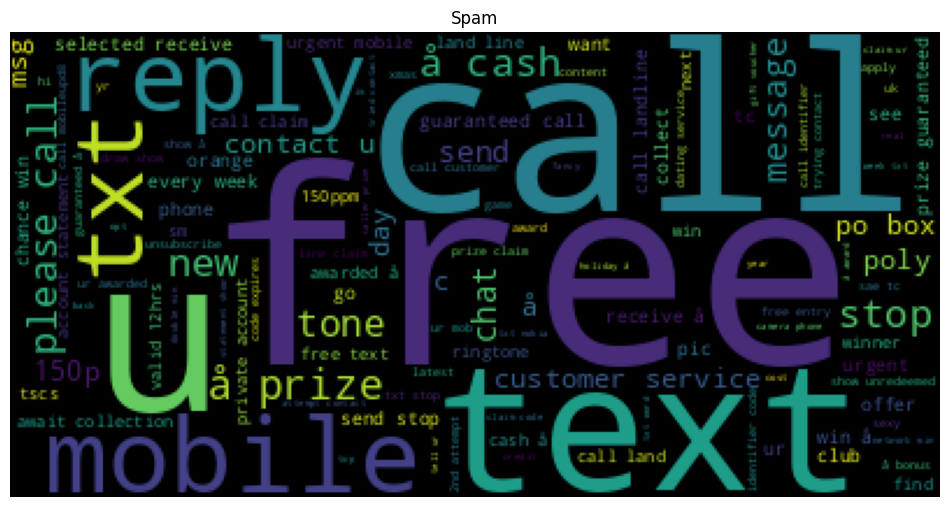

In [11]:
wordcloud = WordCloud().generate(words_spam)
plt.figure(figsize = (12, 8))
plt.imshow(wordcloud)
plt.axis("off")
plt.title('Spam')
plt.show()

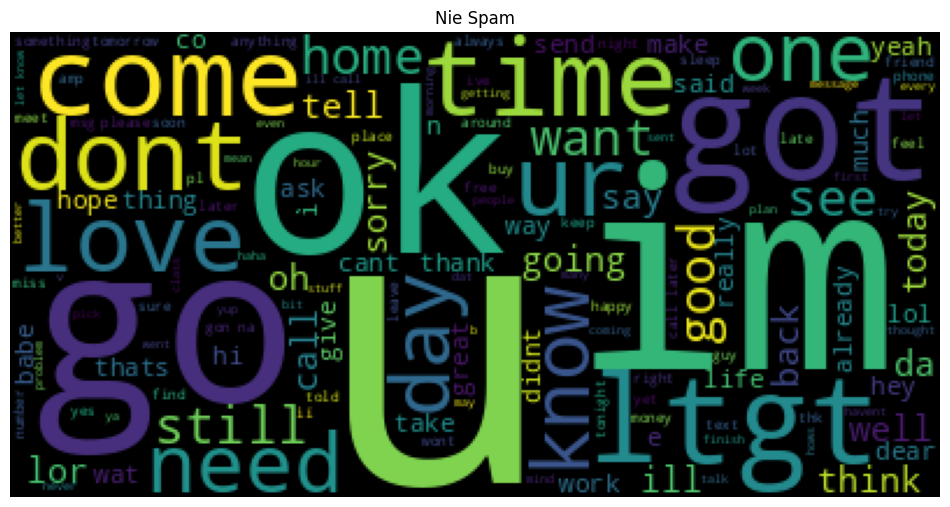

In [12]:
wordcloud = WordCloud().generate(words_notspam)
plt.figure(figsize = (12, 8))
plt.imshow(wordcloud)
plt.axis("off")
plt.title('Nie Spam')
plt.show()

### wektoryzacja

In [13]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(spam_dataset['Lemmatized_Text'].apply(lambda x: ' '.join(x)))
print(X.shape)
y = spam_dataset['Spam']
print(y.shape)

(5572, 8843)
(5572,)


### random forest

In [14]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X, y)
clf.score(X, y)

0.8659368269921034

In [15]:
from sklearn.feature_extraction.text import CountVectorizer
count = CountVectorizer(min_df=0.01, max_df=0.5)
X_count = count.fit_transform(spam_dataset['Lemmatized_Text'].apply(lambda x: ' '.join(x)))
X_count

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 15648 stored elements and shape (5572, 129)>

In [16]:
clf_v2 = RandomForestClassifier(max_depth=2, random_state=0)
clf_v2.fit(X_count, y)
clf_v2.score(X_count, y)

0.8695262024407753

In [17]:
count.vocabulary_

{'go': 34,
 'great': 39,
 'got': 38,
 'wat': 119,
 'ok': 77,
 'free': 30,
 'win': 123,
 'text': 104,
 'txt': 113,
 'say': 90,
 'already': 0,
 'dont': 24,
 'think': 108,
 'life': 54,
 'around': 5,
 'hey': 42,
 'week': 121,
 'back': 8,
 'like': 55,
 'still': 99,
 'send': 92,
 'even': 25,
 'per': 79,
 'friend': 31,
 'customer': 19,
 'prize': 85,
 'claim': 14,
 'call': 10,
 'mobile': 65,
 'co': 15,
 'im': 47,
 'gon': 36,
 'na': 69,
 'home': 44,
 'soon': 97,
 'want': 118,
 'tonight': 112,
 'ive': 48,
 'today': 110,
 'cash': 13,
 'reply': 87,
 'urgent': 115,
 'right': 88,
 'take': 102,
 'time': 109,
 'next': 72,
 'message': 62,
 'oh': 76,
 'yes': 128,
 'make': 60,
 'way': 120,
 'feel': 27,
 'miss': 64,
 'ur': 114,
 'going': 35,
 'first': 29,
 'da': 20,
 'lor': 57,
 'meet': 61,
 'really': 86,
 'know': 50,
 'lol': 56,
 'always': 2,
 'love': 58,
 'amp': 3,
 'ill': 46,
 'let': 53,
 'work': 124,
 'wait': 116,
 'thats': 106,
 'sure': 101,
 'yeah': 126,
 'tell': 103,
 'anything': 4,
 'thanks': 105,

In [18]:
print(X_count.toarray()[:5])

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
  0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
  0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0

In [19]:
tfidf = TfidfVectorizer(ngram_range=(2, 2), max_df=0.5, min_df=0.001, use_idf=True)

X = tfidf.fit_transform(spam_dataset['Lemmatized_Text'].apply(lambda x: ' '.join(x)))

# Zadanie 17_1: Random Forest
Podziel zbiór na treningowy i testowy, pamiętaj o stratyfikacji. Następnie naucz model Random Forest, z którego wyciągnij feature importance. Na podstawie tego wykonaj selekcję cech i weź jedynie te, których ważność jest większa niż 0.001. Nauczy nowy model Random Forest z wyborem hiperperparametrów, korzystając z GridSearch. Wykorzystaj poznane techniki do wektoryzacji.

Wyniki prześlij Mentorowi jako Jupyter Notebook umieszczony w Twoim GitHubie.

### podzial zbioru na czesc traningowa i testowa

In [20]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0, stratify=y)
print ('Treningowe obserwacje: %d\nTestowe obserwacje: %d' % (X_train.shape[0], X_test.shape[0]))


Treningowe obserwacje: 3900
Testowe obserwacje: 1672


In [21]:
print(X_train.shape)
print(y_train.shape)

(3900, 434)
(3900,)


In [22]:
print(X_test.shape)
print(y_test.shape)

(1672, 434)
(1672,)


### selekcja na podstawie waznosci cech

In [23]:
min_samples_leaf = max(1, int(X_train.shape[0]*0.002))
model_forest = RandomForestClassifier(n_estimators=1000, max_depth=7, min_samples_leaf=min_samples_leaf)
model_forest.fit(X_train, y_train)

,n_estimators,1000
,criterion,'gini'
,max_depth,7
,min_samples_split,2
,min_samples_leaf,7
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [24]:
importances = model_forest.feature_importances_

# maska cech istotnych
mask = importances > 0.001
X_train_selected = X_train[:, mask]
X_test_selected = X_test[:, mask]

print(f"Liczba cech przed selekcją: {X_train.shape[1]}")
print(f"Liczba cech po selekcji: {X_train_selected.shape[1]}")

print(f"Liczba cech przed selekcją: {X_test.shape[1]}")
print(f"Liczba cech po selekcji: {X_test_selected.shape[1]}")

Liczba cech przed selekcją: 434
Liczba cech po selekcji: 89
Liczba cech przed selekcją: 434
Liczba cech po selekcji: 89


In [25]:
print(X_train_selected.shape)
print(y_train.shape)

(3900, 89)
(3900,)


In [26]:
y_train.head()

3467    0
1164    0
5059    0
1721    0
1921    0
Name: Spam, dtype: int64

In [27]:
print(X_test_selected.shape)
print(y_test.shape)

(1672, 89)
(1672,)


In [28]:
y_test.head()

313     0
2241    0
3024    0
3725    0
2644    0
Name: Spam, dtype: int64

### wybor parametrow z wykorzystaniem GridSearch

In [29]:
from sklearn.model_selection import train_test_split, GridSearchCV
param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [None,2,5, 10, 20],
    "max_features": ["sqrt", "log2"]
}

model_fores_new = RandomForestClassifier(random_state=42, n_jobs=-1)

grid = GridSearchCV(model_fores_new, param_grid, cv=3, scoring="f1_macro", n_jobs=-1)
grid.fit(X_train_selected, y_train)

print("Najlepsze parametry:", grid.best_params_)
model_z_grid = grid.best_estimator_

Najlepsze parametry: {'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 200}


### predykcja dla zestawu treningowego i f1 score dla zestawu treningowego

In [30]:
from sklearn.metrics import f1_score
predictions_train = model_z_grid.predict(X_train_selected)
print("F1_score train:", f1_score(y_train, predictions_train))

F1_score train: 0.7294685990338164


### predykcja dla  zestawu testowego i f1 score dla zestawu testowego

In [31]:
predictions_test = model_z_grid.predict(X_test_selected)
print("F1_score train:", f1_score(y_test, predictions_test))

F1_score train: 0.7005649717514124


### 17.3. Analiza tematu dokumentu

In [32]:
from sklearn.decomposition import LatentDirichletAllocation
count_v2 = CountVectorizer(max_df=0.1, max_features=500)
X_count_v2 = count_v2.fit_transform(spam_dataset['Lemmatized_Text'].apply(lambda x: ' '.join(x)))
lda = LatentDirichletAllocation(n_components=7, random_state=2022,
                                learning_method='batch')
X_topics = lda.fit_transform(X_count_v2)

In [33]:
feature_names = count_v2.get_feature_names_out()
for topic_idx, topic in enumerate(lda.components_):
    print(f'Temat: {topic_idx+1}')
    print(' '.join([feature_names[i] for i in topic.argsort()[:-5-1:-1]]))
    print()

Temat: 1
love good day hi happy

Temat: 2
time come get yeah give

Temat: 3
ur ltgt txt send stop

Temat: 4
go im lor home ok

Temat: 5
dont know im want like

Temat: 6
call free ok phone text

Temat: 7
call na thats please claim



#  zad_17_2

Zadanie: metryki
Dla nauczonego modelu policz metryki wspomniane w poznanym module o klasyfikacji na zbiorze testowym oraz policz macierz omyłek.

Wynik prześlij Mentorowi jako Jupyter Notebook umieszczony w Twoim GitHubie.

definicja funkcji liczacej metryki

In [34]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, roc_curve, roc_auc_score, confusion_matrix, classification_report

# Initialize global variables
metrics_dataframe = pd.DataFrame(columns=['Model', 'F1_score', 'AUC'])
models = []
models_names = []

def calculate_metrics(model, name, X_checked, y_checked):
    global metrics_dataframe, models, models_names

    # Store model info
    models.append(model)
    models_names.append(name)

    # Convert one-hot labels to 1D if needed
    if y_checked.ndim == 2 and y_checked.shape[1] == 2:
        y_checked_labels = np.argmax(y_checked, axis=1)
    else:
        y_checked_labels = y_checked

    # Predictions
    predictions = model.predict(X_checked)

    # Predicted probabilities (only for current model)
    if hasattr(model, "predict_proba"):
        pred_proba = model.predict_proba(X_checked)[:, 1]  # positive class
    else:
        raise ValueError("Model has no predict_proba method")

    # Classification report
    print(f"\nClassification report for {name}:\n")
    print(classification_report(y_checked_labels, predictions))

    # Confusion matrix
    plt.figure()
    cm = confusion_matrix(y_checked_labels, predictions)
    ax = sns.heatmap(cm, annot=True, cmap='Blues', fmt='.0f')
    ax.set_title(f'Confusion Matrix ({name})\n\n')
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values')
    plt.show()

    # ROC curve (only use current model's probabilities)
    fpr, tpr, _ = roc_curve(y_checked_labels, pred_proba)
    roc_auc = roc_auc_score(y_checked_labels, pred_proba)

    plt.figure(figsize=(6, 6))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.4f})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

    # F1 score
    f1_metric = f1_score(y_checked_labels, predictions)

    # Update metrics dataframe
    metrics_dataframe = metrics_dataframe.append({
        'Model': name,
        'F1_score': f1_metric,
        'AUC': roc_auc
    }, ignore_index=True)

    return metrics_dataframe

## metryki dla zbioru treningowego

In [36]:
from sklearn.metrics import f1_score
predictions_train = model_z_grid.predict(X_train_selected)
print("F1_score train:", f1_score(y_train, predictions_train))


predictions_test = model_z_grid.predict(X_test_selected)
print("F1_score train:", f1_score(y_test, predictions_test))

F1_score train: 0.7294685990338164
F1_score train: 0.7005649717514124



Classification report for grid:

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      3377
           1       0.99      0.58      0.73       523

    accuracy                           0.94      3900
   macro avg       0.96      0.79      0.85      3900
weighted avg       0.95      0.94      0.94      3900



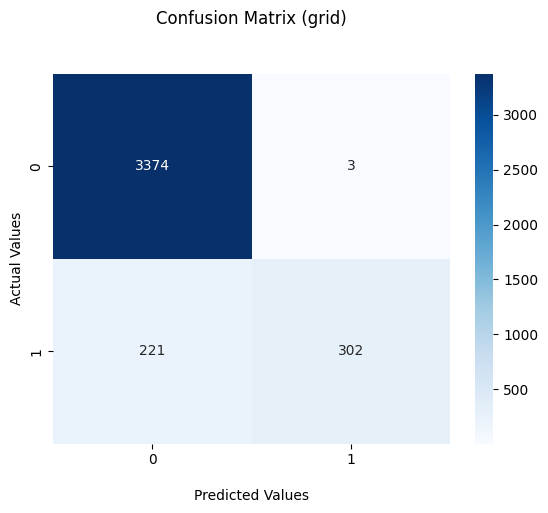

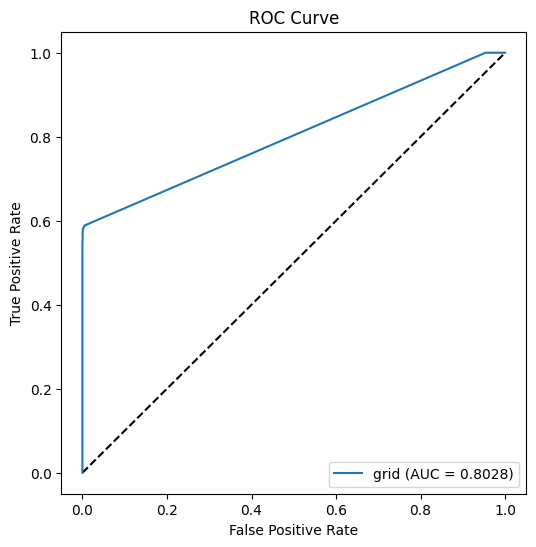

C:\Users\monas\AppData\Local\Temp\ipykernel_29880\2040693074.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_dataframe = metrics_dataframe.append({


,Model,F1_score,AUC
0,grid,0.729469,0.8028


In [37]:
calculate_metrics(model_z_grid, 'grid', X_train_selected, y_train)

## metryki dla zbioru testowego


Classification report for grid:

              precision    recall  f1-score   support

           0       0.94      1.00      0.96      1448
           1       0.95      0.55      0.70       224

    accuracy                           0.94      1672
   macro avg       0.94      0.77      0.83      1672
weighted avg       0.94      0.94      0.93      1672



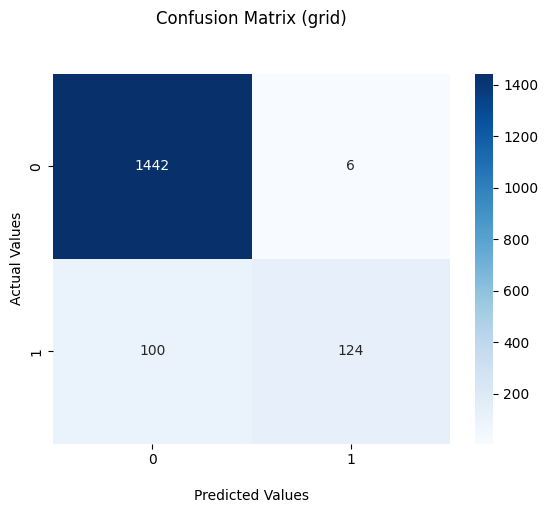

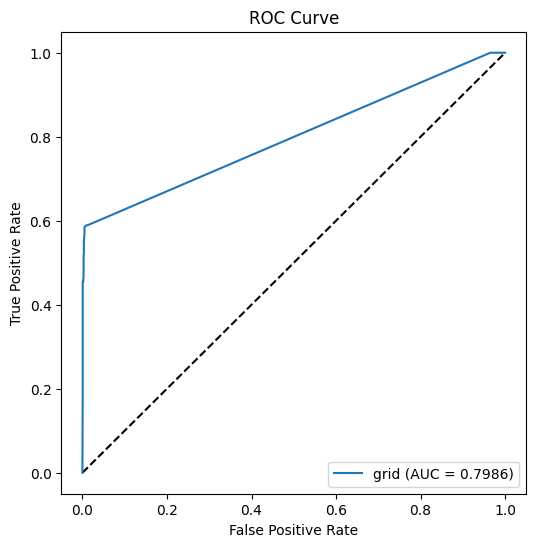

C:\Users\monas\AppData\Local\Temp\ipykernel_29880\2040693074.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_dataframe = metrics_dataframe.append({


,Model,F1_score,AUC
0,grid,0.729469,0.802800
1,grid,0.700565,0.798608


In [38]:
calculate_metrics(model_z_grid, 'grid', X_test_selected, y_test)